## Imports

In [1]:
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from openseize import producer
from openseize.io.edf import Reader
from openseize.io.annotations import Pinnacle, as_mask
from openseize import demos
from openseize.filtering.iir import Notch
from openseize.spectra import estimators, metrics
from openseize.spectra.plotting import banded, STFTViewer
from openseize.resampling.resampling import downsample

## Introduction

In the Fourier Transform demo, we explored how the Discrete Fourier Transform (DFT) takes a sequence from the time domain space and maps it to a new sequence in the frequency domain space. This method of spectral analysis is fine for deterministic signals like sines and cosines but is not appropriate for random signals. The DFT of a random signal is itself random. This means that the DFT will vary from one experiment to the next.
<br>
&emsp; This tutorial will present two methods for exploring the spectral content of discrete random signals. To determine which method to use, you will need to answer this key question; <b><i>Is the random signal whose frequency content I wish to know stationary?</i></b>. To understand why this question is important, we'll start this demo by defining a random process and work our way towards stationarity. It is strongly encouraged that all readers who wish to perform spectral analysis carefully consider the following mathematics discussion.

## Mathematics

### Random Processes

A discrete-time random process is a collection of random variables $X_1, X_2, X_3, ...$ that are usually indexed by time. Formally a random process is written as:

$$
\{X[n], \ n \in \mathbb{Z}\} \quad (1) 
$$

**Lets plot a simple random process $\{X[n], \ n=0, 1, 2, ...\}$ where each X[n] is ~ Normal(0,1).**

In [2]:
def gaussian_rp(size, seed=None):
    """Returns a random process with size elements using a random seed."""
    
    rng = np.random.default_rng(seed)
    return rng.normal(0,1, size=size)

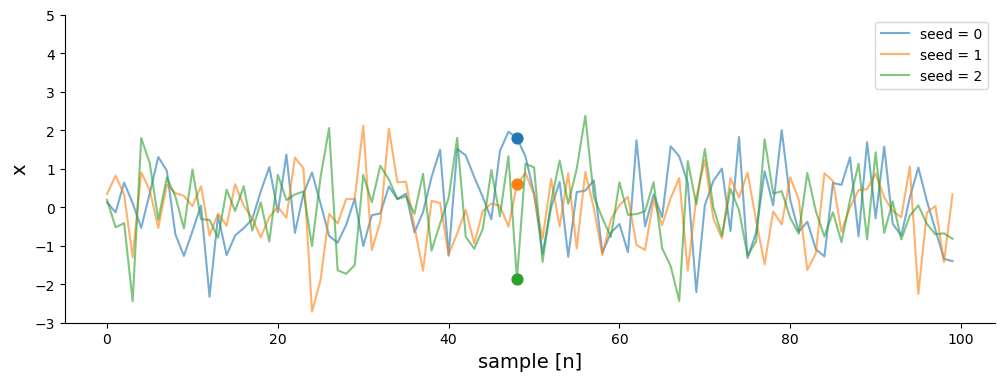

In [3]:
# create three 100 element "realizations" of our random process
# using different random seeds
seeds = np.arange(3)
x = [gaussian_rp(100, s) for s in seeds]

# plot each realization 
fig, ax = plt.subplots(figsize=(12, 4))
for signal, seed in zip(x, seeds):
    ax.plot(signal, label='seed = {}'.format(seed), alpha=0.6)

#configure the plot
ax.set_xlabel('sample [n]', fontsize=14)
ax.set_ylabel('x', fontsize=14)
ax.set_ylim([-3, 5])
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.legend(loc='upper right')

# plot the 48th element for each realization
ax.scatter(48, x[0][48], s=60)
ax.scatter(48, x[1][48], s=60)
ax.scatter(48, x[2][48], s=60)

plt.show()

For each random seed we get a unique path called the <b>sample path or realization of the random process</b>. Each point in each path is a random variable. We have plotted the 48th sample random variable $X[n=48] = x_{48}$ on each sample path using a colored dot. It is important to note that each sample path drew its random variables from the same probability distrubution -- the Normal(0,1) distribution. This is not required, <b>each random variable in a sample path or realization does not need to come from the same probability distribution.</b> We are getting close to defining stationarity but before we do that, we need to examine statistical properties of these sample paths. In particular, we will define the expected value function and correlation function of the random processes that generate sample paths.

### Mean & Correlation Functions

The mean of a random process is defined as:

$$
    \mu_X[n] = E\{X[n]\} \quad (2)
$$

Be careful, this is not the mean value of a sample path. That would be just a constant number. This is a mean function. At each index n, we compute the expected value of X[n]. In our case above, the expected value is E[Normal(0,1)] which is 0. So $\mu_X[n] = 0$ at each n. Another way to think about this is to generate many many sample paths and at each index average across sample paths. This is the mean function. Formally, we define it as:
$$
    \mu_X[n] = E\{X[n]\} = \sum \limits_{n=-\infty}^\infty P(X[n]) X[n] \quad (3)
$$

Technical note, we have the sum from $-\infty$ to $\infty$. Thats no problem for EEGs where the samples run from 0 to some finite number N because we just set the probability $P(X[n])$ to be 0 everywhere except $n \in [0, N]$. 

The mean function gives us the expected value of X[n] at sample n but it does not tell us how the samples in a sample path are related. That is, given indices p and q along a sample path, is their a relationship between X[p] and X[q]? The autocorrelation function tells us how samples generated from a random process are related. The autocorrelation, or simply correlation function, is defined as:

$$
    R_X(p, q) = E\{X[p]X[q]\} \quad \textrm{for} \quad p,q \in [0, N] \quad (4)
$$

And the autocovariance, more simply called the covariance, is defined as:

$$
    C_X(p, q) = E\Bigl\{(X[p]-E\{X[p]\}) \ (X[q]-E\{X[q]\})\Bigr\} \quad \textrm{for} \quad p,q \in [0, N] \quad (5)
$$ 

Interpreting $C_X$, when X[p] and X[q] are both large compared to their means, $C_X$ will be positive. Conversely, when X[p] and X[q] are large but negative, $C_X$ is again positive. If X[p] is near its mean then no matter what X[q] is the covariance will be small. <b>In summary, the covariance tracks how X[p] and X[q] move together.</b>  

### Stationary Random Processes

In our random process example, we knew that each random variable along a a single sample path came from the same normal distribution. Mathematicians refer to this as <b>Strict-Sense Stationary</b>. In terms of the joint probability distribution function (PDF) P, we can write this as: 

$$
    P(X[p], X[q]) = P(X[p+\Delta], X[q+\Delta]) \quad \textrm{for all} \quad p, q, \Delta \in [0,N] \quad (6)
$$

In words, <i><b>a time shift of two points in a random process does not change the processes joint statistical properties</b></i>. The joint PDF is the same under translation. This property defines Strict Sense Stationary. For EEG data, we do not know if such a distribution exist nor if this distribution changes across the sample indices. However, there is a weaker form of stationarity called <b>Weak or Wide-Sense Stationary</b>. This will give us a practical definition of stationarity without requiring us to know the PDF.

A random process is called Wide-Sense stationary if its mean function $\mu_x[n]$ and its correlation function $R_X(p, q)$ do not change when the samples are shifted in time. These properties can be written as:

$$
    E\{X[p]\} = E\{X[q]\}
$$

$$
    R_X(p, q) = E\{X[p]X[q]\} = E\{X[p+\Delta]X[q+\Delta]\}
$$


This definition can be simplified a little more. Since the mean function does not depend on time, $\mu_X[n] = \mu_X \ \textrm{for all} \ n$. Second, the correlation function does not depend on p and q individually, it depends on the difference between p and q. So we can write $R_X(p, q) = R_X(p-q)$. This means if we are at sample p, the correlation function depends only on the distance in samples ($\tau$) away from p. Therefore $R_X(p, q) = E\{X[p]X[p+\tau]\} = R_X(\tau)$.

<b> An EEG random process is Wide-Sense Stationary (WSS) if:</b>

$$
    \mu_X[n] = \mu_x  \quad \textrm{ for all} \ n \in \mathbb{Z}  \quad (7) 
$$

$$
    R_X[p, q] = R_X(p-q) = E\{X[p]X[p+\tau]\} = R_X(\tau) \quad \textrm{for all} \ p,q, \tau \in \mathbb{Z} \
    \quad (8)
$$

Lets pause here to absorb what we've just learned. For a WSS random process, the mean does not change in time. Second, we can pick any sample from the signal and the correlation function measured from that sample will depend only on how far we are from that sample and not on the sample we picked. To explore a little further, consider a Normal(0,1) random processes. In this case the variance is one and the samples are independent and identically distributed with a mean of 0. So the correlation function is:

$$
    \begin{align*}
        R(\tau) = \begin{cases}
                    E\{X^2[p]\} = 1 & \tau=0\\
                    E\{X[p]X[p+\tau]\} = E\{X[p]\}E\{X[p+\tau]\} = 0 & \tau \neq 0
                \end{cases} \quad (9)
    \end{align*}        
$$

**Lets plot the correlation function for each of the three sample paths of our Normal(0,1) example to see if Eqn. 9 holds.**

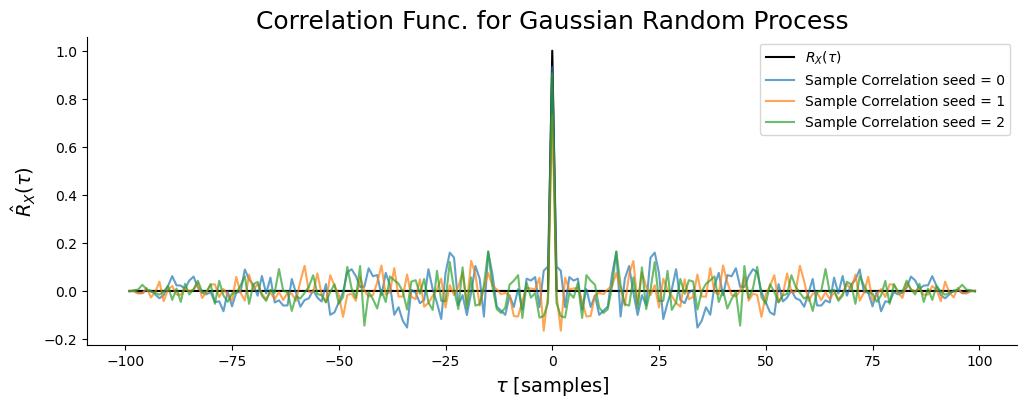

In [4]:
# create  the same 3 sample paths of our N(0,1) gaussian process again
seeds = np.arange(3)
x = [gaussian_rp(100, s) for s in seeds]

# compute the correlation function of each sample path and the length
correlations = [np.correlate(s, s, mode='full')/len(s) for s in x]
corr_len = len(correlations[0])

# plot the correlation functions 
fig, ax = plt.subplots(figsize=(12,4))

# these are the centered taus since tau can be + or -
taus = np.arange(corr_len)-(corr_len)//2

#plot the correlation function of Eqn. 9
actual = np.zeros(len(taus))
actual[len(taus)//2] = 1
ax.plot(taus, actual, color='k', label=r'$R_X(\tau)$')

# plot the sample correlation functions
for corr, seed in zip(correlations, seeds):
    ax.plot(taus, corr, alpha=0.7,label='Sample Correlation seed = {}'.format(seed))
    

ax.set_xlabel(r'$\tau$ [samples]', fontsize=14)
ax.set_ylabel(r'$\hat{R}_X(\tau)$', fontsize=14)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.set_title('Correlation Func. for Gaussian Random Process', fontsize=18)
ax.legend()
plt.show()

Technical note; notice in the plot, we called the correlation function $\hat{R}_X(\tau)$. Thats because we are approximating the actual correlation function, given in Eqn. 9 with simulated sample paths. This approximation reflects the fact that the expectation value is only using a 100 samples in each path and not an infinite number of samples. Thus $\hat{R}_X(\tau)$ approaches $R_X(\tau)$ as the number of samples in each sample path increase. You can test this out by increasing the number of samples in the above cell (line 3).

For this example, the correlation function is only a function of $\tau$, the difference between any two samples (see Eqn. 9). So this process is wide-sense stationary. <b>How might we tell if an EEG random process is wide-sense stationary? </b>This important question can be answered at several different levels. First there is visual inspection of the sample path. If we observe changes in the mean or variance of a signal or pronounced trends or cycles then the signal is non-stationarity. These are the obvious tests. More statistically satisfying tests are parametric tests such as the Dickey-Fuller test for unit roots and non-parameteric test that examine local Fourier spectra (Basu 2009). The reference section of this demo list a few papers for the interested reader. 

At this point it is natural to ask <b><font color='firebrick'>What does the correlation function and this discussion of stationarity have to do with spectral analysis?</font></b>. We are now at the heart of spectral analysis. Lets keep going.

### Power Spectral Density

#### Weiner-Khintchine-Einstein Theorem

The <b>Power Spectral Density (PSD) of a wide-sense stationary signal is the Fourier transfrom of the correlation function $R_X(\tau)$.</b> This holds for both a continuous (left eqn.) or discrete (right eqn.) random process.
<br>
<br>
<p style="text-align: center;">
    $
    S_X(\omega) = \int \limits_{-\infty}^{\infty}R_X(\tau)e^{-i\omega \tau}d\tau \quad \quad S_X(\omega) = \sum \limits_{\tau=-\infty}^{\infty}R_X[\tau]e^{-i\omega \tau} \quad (10)
    $ 
</p>
<br>
<br>
and the correlation function can be written in terms of the PSD using the inverse transform:
<br>
<br>
<p style="text-align: center;">
    $
    R_X(\tau) = \int \limits_{-\infty}^{\infty}S_X(\omega)e^{i\omega \tau}d\omega \quad \quad  R_X(\tau) = \sum \limits_{\omega=-\infty}^{\infty}S_X(\omega)e^{i\omega \tau} \quad (11)
    $ 
</p>
<br>
<br>

These are big definitions and we need to look at them closely. Consider when $\tau=0$. In this case, 
<br>
<br>
<p style="text-align: center;">
    $
    R_X(0) = E\{X^2(t)\} = \int \limits_{-\infty}^{\infty}S_X(\omega)d\omega \quad \quad R_X(0) = E\{X^2[n]\} = \sum \limits_{\omega=-\infty}^{\infty}S_X(\omega) \quad (12)
    $ 
</p>

In Eqns. 12, $E\{X^2[n]\}$ is the average power of x[n]. Nautrally, this average power in the time domain is equivalent to summing the power spectral density over all frequencies $\omega$. That is why $S_X(\omega)$ is understood to be a density. In fact, there is a theorm called Parseval's theorem that says total power in the time domain exactly equals the total power in the frequency domain.
<br>
&emsp; To get an intuition for Eqns. 10, consider that $R_X$ will have peaks at non-zero values of $\tau$ if the signal contains periodic components. At these values of $\tau$ the integral in Eqn. 10 adds a small contribution to the PSD by influencing the amplitude of the sines and cosines in the $e^{-i \omega \tau}$ term. The idea that periodicity reflected in the shape of $R_X$ in the time domain contributes to the PSD, a function in the frequency domain, is key to understanding these transforms.

At this point, we have a method for computing the Power Spectral Density, 
1. given a wide-sense stationary signal, we compute its correlation function
2. we transform the correlation function to frequency space using the DFT giving us the PSD.  

However, computing the correlation function is expensive. Each point in the signal is multiplied by all other points in the signal. This results in N<sup>2</sup> operations for a signal of length N. A corollary to the WKE theorem is <b> the PSD of a wide-sense stationary signal may be estimated by averaging the squared magnitude of the Fourier Transform of the signal x[n]</b>.

Given a WSS random process signal x[n] and  its DFT $X^F(\omega)$, The PSD $S_x(\omega)$ is approximated by:

$$
    S_X(\omega) = E\{|X^F(\omega)|^2\}  \quad (13)
$$

At this point it may not be clear what we are averaging over. Recall that the DFT (see Fourier demo), partitions the frequenies into NFFT discrete frequencies. So for a signal x[n] we would partition the signal into NFFT chunks, compute the DFT of each chunk and then average the magnitude squared to estimate the PSD,  $S_X(\omega)$. This is called Bartlett's method. However, we have also seen that partitioning x[n] performs truncation of the signal. When we truncate any signal we create oscillations in the frequency domain (See Dirichlet Kernel in filtering demo). To avoid this, we can window the signal before computing the DFT. Since windowing reduces the weights at the window edges, windowing reduces the contribution of edge samples to the PSD. To account for this, the windows are typically overlapped at 50%. This is called Welch's method for estimating the PSD. The average in Eqn 13 is the average of the overlapped NNFT-lengthed **estimatives**.
<br>
<br>
One thing to note about both the Bartlett and Welch methods is that each is ideally suited for iterative computation as they only require a single NFFT chunk at any one time. Scipy requires an in-memory array to estimate the PSD negating this memory savings. Openseize, on the other hand, can take an in-memory array or a producer. This allows Openseize to estimate the PSD of any sized array consuming only the amount of memory needed to hold 1 NFFT chunk at a time. Let's now look into the call signature of Openseize's PSD estimator and compare with Scipy.

## PSDs in Openseize

Openseize provides estimators for spectral content in the spectra module. As usual we'll start by asking for help.

In [5]:
help(estimators.psd)

Help on function psd in module openseize.spectra.estimators:

psd(data, fs, axis=-1, resolution=0.5, window='hann', overlap=0.5, detrend='constant', scaling='density')
    A power spectrum (density) estimator using Welch's method.
    
    Welch's method divides data into overlapping segments and averages the
    modified periodograms for each segment. This estimator can process 
    ndarrays or producer of ndarrays allowing it to estimate the PSD for
    large data sets.
    
    Args:
        data: An ndarray or producer of ndarrays
            A data producer whose power spectral is to be estimated.
        fs: int
            The sampling rate of the data.
        axis: int
            The sample axis of the data. The estimate will be 
            carried out along this axis.
        resolution: float
            The frequency resolution of the estimate in Hz. The resolution
            determines the number of DFT frequencies between [0, fs) to use
            to estimate the powe

This is very similar to Scipy's Welch method except that you pass a freqeuncy bin resolution. This means that unlike Scipy, the chunksize will be NFFT where NFFT = fs / resolution always. Scipy allows for a chunksize that is different than NFFT called nperseg but it's behavior is fundamentally the same.

Now we need to get the demo data to examine. We will examine the PSD of channel 0 of the demo data over a range of time that the signal appears stationary. Be skeptical here, we have not done any test to verify stationarity so don't read into the results too much.

In [6]:
# get the demo data and set a reader to read only channel 0
fp = demos.paths.locate('recording_001.edf')
reader = Reader(fp)
reader.channels = [0]

In [7]:
# By examining the data, we think 10s to 20s is stationary 
# -- but don't hold us to that
fs = 5000
signal = reader.read(fs*10, fs*20).flatten()

In [8]:
# we know beforehand there is some 60 Hz line noise so we filter it out
notch = Notch(fstop=60, width=10, fs=fs)
fsignal = notch(signal, chunksize=1000, axis=-1)

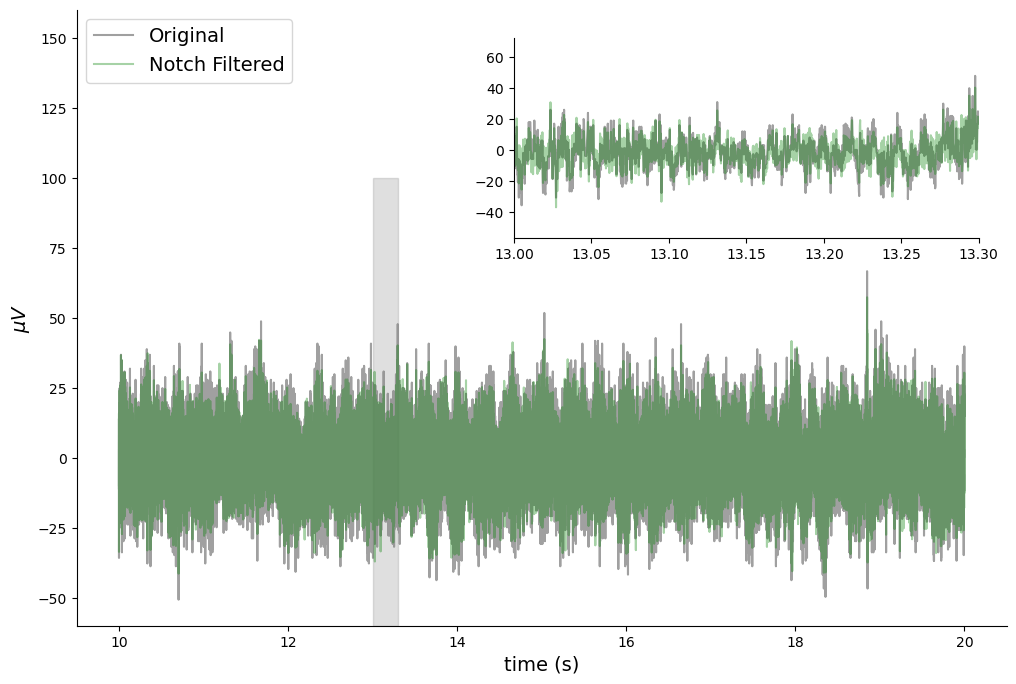

In [9]:
# lets plot this original and filtered data
times = np.arange(10, 20, 1/fs)
# create a figure and inset
fig, ax = plt.subplots(figsize=(12,8))
axinset = inset_axes(ax, width="50%", height=2, loc=1, borderpad=2)
axarr = [ax, axinset]

axarr[0].plot(times, signal, color='gray', alpha=0.75, label='Original')
axarr[0].plot(times, fsignal, color='green', alpha=0.35, label='Notch Filtered')
axarr[0].set_ylim([-60, 160])
axarr[0].legend(loc='upper left', fontsize=14)

#inset
axarr[1].plot(times, signal, color='gray', alpha=0.75)
axarr[1].plot(times, fsignal, color='green', alpha=0.35)
axarr[1].set_xlim([13,13.3])

rect = Rectangle((13,-60), .3, axarr[0].get_ylim()[-1], color='gray', alpha=.25)
axarr[0].add_patch(rect)

axarr[0].set_xlabel('time (s)', fontsize=14)
axarr[0].set_ylabel(r'$\mu V$', fontsize=14)
[ax.spines.top.set_visible(False) for ax in axarr]
[ax.spines.right.set_visible(False) for ax in axarr]

plt.show()

Now we are ready to compute the PSD of this 10 second section of the data. We'll compute it with Opensieze and compare against Scipy. We'll also time each too get a feel for operational speed.

In [10]:
# compute the psd using openseize using the default settings of a Hann window,
# resolution=0.5Hz and an overlap of 50%. The cnt is how many averages were used
# estimate the PSD.

t0 = time.perf_counter()
cnt, freqs, op_psd = estimators.psd(fsignal, fs)
elapsed = time.perf_counter() - t0
print('Openseize computed the PSD of {} secs of data in {} secs'.format(10, elapsed))

Openseize computed the PSD of 10 secs of data in 0.011764695000238135 secs


Lets now compute the same with scipy and compare.

In [11]:
# scipy's nperseg is just the fs / resolution = 5000 / 0.5 = 10000 
t0 = time.perf_counter()
freqs, sp_psd = sp.signal.welch(fsignal, fs=fs, nperseg=10000)
elapsed = time.perf_counter() - t0
print('Scipy computed the PSD of {} secs of data in {} secs'.format(10, elapsed))

Scipy computed the PSD of 10 secs of data in 0.00942804900023475 secs


Scipy operates faster on small data but as the data size increases, Openseize's PSD can operate on a producer rather than an array. This will provide a significant speed boost because the data array will no longer be loaded into memory. Let's plot the PSDs and confirm they are identical

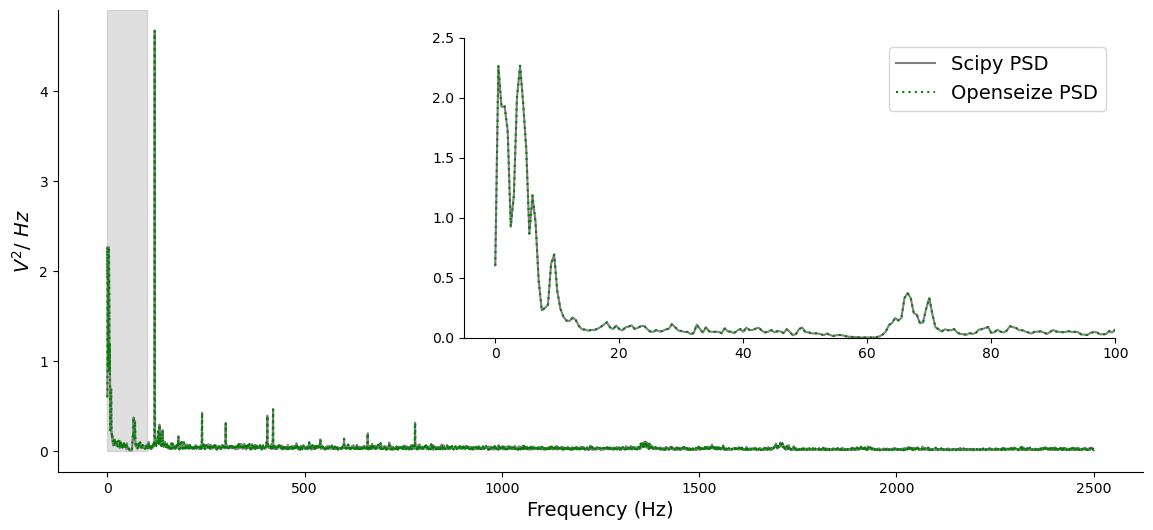

In [12]:
# Plot Openseize and Scipy's PSD for the 10s of data
fig, ax = plt.subplots(figsize=(14,6))

# create a zoomed axis inset into the main axis to show low freq details
axinset = inset_axes(ax, width="60%", height=3, loc=1, borderpad=2)
axarr = [ax, axinset]

# main axis plot
axarr[0].plot(freqs, sp_psd, color='gray')
axarr[0].plot(freqs, op_psd, color='green', linestyle=(0, (1,2)))
#add rectangle
rect = Rectangle((0,0), 100, axarr[0].get_ylim()[-1], color='gray', alpha=.25)
axarr[0].add_patch(rect)

#inset zoomed plot
axarr[1].plot(freqs, sp_psd, color='gray', label='Scipy PSD')
axarr[1].plot(freqs, op_psd, color='green', linestyle=(0, (1,2)), 
              label='Openseize PSD')
axarr[1].set_xlim([-5, 100])
axarr[1].set_ylim([0, 2.5])

#configure
axarr[0].set_xlabel('Frequency (Hz)', fontsize=14)
axarr[0].set_ylabel(r'$V^2 /\ Hz$', fontsize=14)
[ax.spines.top.set_visible(False) for ax in axarr]
[ax.spines.right.set_visible(False) for ax in axarr]

axarr[1].legend(fontsize=14)
plt.show()

In [13]:
# since we only see 1 curve above it looks like openseize PSD = Scipy PSD
print('Does Openseize PSD == Scipy PSD? -> {}'.format(np.allclose(sp_psd, op_psd)))

Does Openseize PSD == Scipy PSD? -> True


There are a few important tools that are provided in Openseize to help you analyze PSDs. We summarize them below:
- <b>Normalization</b>
The PSD computed on the 10s of data is unnormalized. The electrode that was used to compute this result has a particular impedance. Impedance can be thought of as a frequency dependent resistance. Since $V=IR$, the PSD, which has units $V^2/Hz$, depends on the electrodes impedance. In fact, the PSD depends on two impances; the impedance of the electrode and the impedance of the brain. White-matter measurements of impedance are in the ballpark of 1 k$\Omega$. Electrode impedances can vary widely from 100 - 5000 $\Omega$. Thus, the electrode impedance value can strongly influence the electrodes contribution to the PSD. A complicating factor is that it is difficult to estimate an electrode's impedance after implantation. At the end of the day, if you are not certain of the impedance of your electrode, interpreting the amplitude of the PSD is dubious. Therefore, it is recommended to normalize the data. Openseize provides band-normalization. This method computes the total power (area below PSD) between two frequencies usually in the range [0, 100] Hz and divides the PSD by this power. This is still a bit unsatisfactory because it divides the PSD by a constant. Typically the impedance is a function that declines with frequency. So the PSD at low frequencies are weighted more heavily (have higher $V^2$) than high-frequencies but without knowledge of this function dividing by the total power is a first approximation.<br>
- <b>Confidence Intervals</b>
The PSD is measured from a sample path of a random process. We can therefore ask, Given the number of NFFT sized estimatives, if I were to measure again how close would the new PSD be to the last PSD. To address this, we can construct a Confidence Interval around the PSD. Since the PSD is a sum of squared random variables $|X(\omega)|^2$, the PSD follows a Chi-squared distribution. Knowing this and the number of nfft sized estimates we can construct a confidence interval and plot it with our PSD. This functionality can be found in the spectra.metrics module of Openseize.<br>
- <b>Plotting</b>
Openseize provides a few tools for plotting PSDs and their confidence intervals in the spectra.plotting module.

## A Cautionary Example

The mathematics section of this demo showed how the PSD can be computed by averaging NFFT lengthed estimatives, $|X^F(\omega)|^2$, from a larger data sequence. <b>This was developed under the assumption of stationarity</b>. It really makes no sense to average DFT estimates if each DFT estimate comes from a different probability distribution. To give some idea of what can go wrong if you compute a PSD from non-stationary data, we will walk through an example of computing the PSD of the demo data. Specifically, we will compute and compare the PSDs from three consecutive chunks of the hour-long demo data for channel 0. Please note, this is <u>not</u> a test for stationarity but it can rule out stationarity. <br>
&emsp; We will first build a set of masked producers each of which yields values during a 10 min epoch. Second, we will notch filter each producer and third, we will compute and compare the PSDs.

**Build masked producers for three 10 min epochs.**

In [14]:
pros = dict()

fs = 5000
duration = reader.shape[-1] #the length of each mask
epochs = [(0, 10),(10, 20), (20, 30)] # epochs are in minutes

for start, stop in epochs:
    
    # build a mask the length of signal with True in epoch
    mask =  np.zeros(duration, dtype='bool')
    mask[start*fs*60: stop*fs*60] = True
    
    # build a masked producer for each epoch
    pros['{} to {} mins'.format(start, stop)] = producer(reader, chunksize=5e6, 
                                                         axis=-1, mask=mask)

**Compute the PSDs of each notch-filtered producer.**

In [15]:
PSDs = dict()

notch = Notch(fstop=60, width=10, fs=fs)

for epoch_name, pro in pros.items():
    
    # noth filter the producer
    filtpro = notch(pro, chunksize=5e6, dephase=False, axis=-1)
    
    # PSD estimate of the filtered producer
    cnt, freqs, psd = estimators.psd(filtpro, fs, resolution=.5)
    PSDs[epoch_name] = (cnt, freqs, psd)

**Compare the PSD estimates across epochs.**

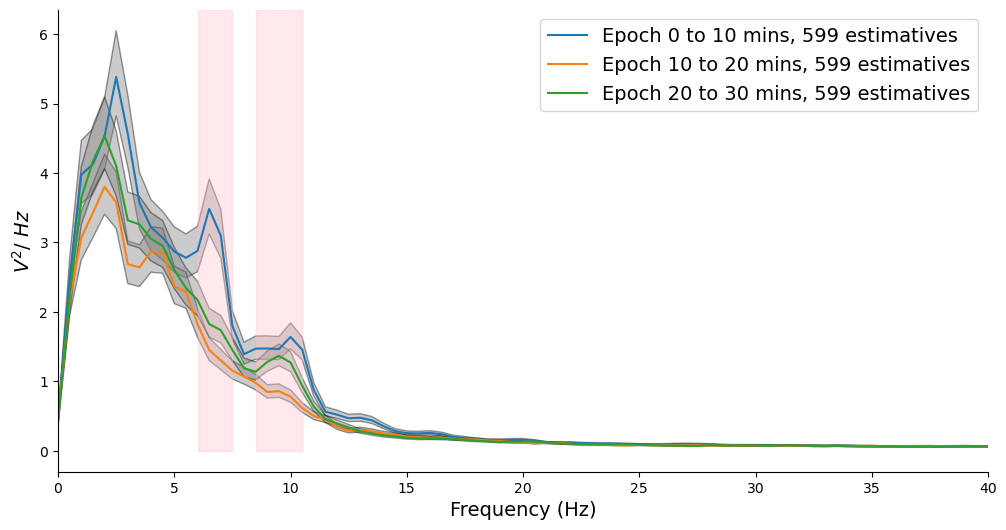

In [16]:
fig, ax = plt.subplots(figsize=(12,6))

for epoch, (cnt, freqs, psd) in PSDs.items():
    
    ax.plot(freqs, psd.flatten(), label='Epoch {}, {} estimatives'.format(
        epoch, cnt))
    
    # add a confidence interval to each PSD
    ci = metrics.confidence_interval(psd, cnt, alpha=0.05)
    banded(freqs, *ci[0], ax=ax)
    
# limit freq axis
ax.set_xlim([0,40])
ax.legend(fontsize=14)

#add rectangles where PSDs are very different
rect = Rectangle((6,0), 1.5, ax.get_ylim()[-1], color='pink', alpha=.35)
rect2 = Rectangle((8.5,0), 2, ax.get_ylim()[-1], color='pink', alpha=.35)
ax.add_patch(rect)
ax.add_patch(rect2)

#configure
ax.set_xlabel('Frequency (Hz)', fontsize=14)
ax.set_ylabel(r'$V^2 /\ Hz$', fontsize=14)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

plt.show()

**Plot Interpretation**

The plot shows the un-normalized PSDs for each of the three consecutive epochs. They are un-normalized because the data all comes from a single electrode, the amplitude differences in this plot represent real power density differences. Second, we have plotted the 95% confidence intervals. The CIs reflect how confident we are that new data, that follows the same distribution will lie near the plotted data. The interval widths depend on how many times we averaged to compute each PSD. In the case of non-overlapping windows, this would be how many NFFT chunks fit into 10 mins. We have labeled the number of estimates for this example (which does overlap windows) in the legend.<br> 
<br><b>Importantly, we see differences in the amplitudes and shapes of the PSD that indicate non-stationarity</b>. In epoch 0 to 10 minutes, there is a strong peak at 6-7 Hz that is not present in the other epochs. We can say that this epoch inlcuded 6-7 Hz sinusoids that appeared and then disappeared. That is non-stationary! If we were to average across these epochs (i.e. compute the PSD from 0 to 30 mins), this 6 Hz signal might be lost. If we were to split this data further say into 5 min chunks, would new frequencies pop-out? <br>
<br>
This highlights the flaw in our assumption of stationarity with this data. <b>The PSDs are changing in time and averaging is very misleading. </b> As an analogy, consider you want to measure ocean wave heights. So you go out in a boat and drop a buoy and start to measure. On the first day of measurements, the ocean is calm and has only low frequency swells. On the second day a storm blows in and you see new higher frequency choppy waves you didn't see on day one. If you average this data, you misrepresent the data as people will conclude that their is always both low frequency swells and high-frequency chop. Worse yet, you may loose critical frequency information because the different frequencies may mask each other in the PSD. <br>
<br>
In summary, computing the PSD of EEG data needs to be approached with caution because like the ocean analogy, the brain has different states and averaging across these states may misrepresent your data and obscure important findings. Therefore, remember to ask <b>is my data stationary enough to have its frequency content accurately reflected in a PSD?</b>

## Short-time Fourier Transform

If you tracked with us on the stationarity problem in regards to Power Spectral Density estimation, you may be asking, <b>What do I do if my data is non-stationary?</b> This section presents a time-localized PSD called the Short-time-Fourier Transform which can be used to analyze non-stationary signals.

Recall for a WSS random process signal x[n], we estimated the PSD by averaging the squared magnitude of the Fourier transform.
</br>
</br>
<p style="text-align: center;">
    $
    E\{|X^F(\omega)|^2\} = S_X(\omega)
    $
</p>
</br>

A natural extension of this is to consider storing each estimative $|X^F(\omega)^2|$ instead of averaging. Notice that each estimative corresponds to a time bin containing NFFT samples. So if we include time, we could rewrite the above equation as:
<br>
</br>
<p style="text-align: center;">
    $
    |X^F(\omega, t)|^2 = S_X(\omega, t) \quad (14)
    $
</p>
</br>


<b>The $X^F(\omega, t)$ is called the Short-Time Fourier Transform (STFT).</b> You can think of the squared magnitude of the STFT as the <b>instantaneous PSD.</b> The squared magnitude of the STFT at each time can be represented as a vector. These vectors can be  plotted in time vs. frequency plot called a <b>Spectrogram</b>. Openseize provides an estimator for the STFT and an interactive spectrogram. Lets explore these tools.

In [17]:
help(estimators.stft)

Help on function stft in module openseize.spectra.estimators:

stft(data, fs, axis, resolution=0.5, window='hann', overlap=0.5, detrend='constant', scaling='density', boundary=True, padded=True, asarray=False)
    A Short-Time Fourier Transform estimator.
    
    This estimator is useful for estimating changes in the frequency or 
    phase content of a non-stationary signal over time. 
    
    The STFT breaks a sequence of data into overlapping segments and
    computes a modified (windowed) Discrete Fourier Transform for each
    segment. This results in a sequence of complex values containing the
    frequency and phase content in each segment. These segments are then
    concatenated to create an estimate of the frequency content as
    a function of time X(frequncy, time). This is the STFT estimate.
    
    Args:
        data: An ndarray or producer of ndarrays
            A data producer whose stft is to be estimated.
        fs: int
            The sampling rate of the data.


The call signature is similar to the PSD call signature but the return values now include time and the STFT is a producer of STFT vectors or a 2-D array

In [18]:
# set the channels to compute the STFT of
reader.channels=[0, 1, 2]
fs = 5000
down = 25

# make a producer
pro = producer(reader, chunksize=5e6, axis=-1)

# downsample the data to 100 Hz to make plotting easier to see
downpro = downsample(pro, M=down, fs=fs, chunksize=5e6, axis=-1)

# make a producer of notch filtered data
notch = Notch(fstop=60, width=10, fs=fs/down)

filtpro = notch(downpro, chunksize=5e6, axis=-1, dephase=False)

# compute the STFT returning it as an array
freqs, t, result = estimators.stft(filtpro, fs/down, axis=-1, asarray=True)

An important note about memory. The STFT estimator allows you to return the result as an array. Since the estimator consumes NFFT sized segements for each estimative this reduces the size of the data dramatically (by a factor of ~ fs). It is anticipated that this will fit into memory always but just in case you can set 'asarray' to False and return a producer until you are ready to consume it.
<br>
<br>
So we have the STFT but to plot it on a spectrogram we need to compute its magnitude squared.

In [19]:
x = np.abs(result)**2
print('result shape = ', x.shape) #chs x freqs x times

result shape =  (3, 201, 3776)


So we've got the squared magnitude and are ready to call the STFT interactive viewer. Before we do that lets take a look at this viewer class.

In [20]:
print(STFTViewer.__doc__)

An interactive matplotlib figure for plotting the magnitude of
    a Short-Time Fourier transform of multichannel eeg data.

    Attrs:
        data (ndarray):     The squared norm of the STFT array with 
                            shape channels x frequencies x time.
        freqs (1-D array):  An array of STFT frequencies in Hz.
        time (1-D array):   An array of STFT times in secs.
        scale (str):        String specifying a scaling function to apply to
                            data prior to display. Default is the dB power 
                            scale = 10 * np.log10(data). May be None.
        chs (seq):          Sequence of channel indices to display. Default 
                            None will plot all channels.
        names (seq):        Sequence of channel names to display on
                            subplots.
        stride (int):       The amount of data in secs to display to each
                            subplot of the viewer. This stride stradd

The data will be the squared magnitude we just computed. The stride setting will allow us to view small sections of the data at a time. The default is 2 mins worth of data. There will be a slider widget to update which section you are currently viewing. Also take note that the viewer will scale the data to the decibel scale for easier visualization.

In [21]:
# This will open an interactive plot. 
# play around with it. There are widgets to 
# 1. adjust the stride number
# 2. adjust the frequencies
# 3. standard widgets for zoom etc.
%matplotlib qt
STFTViewer(freqs, t, x)

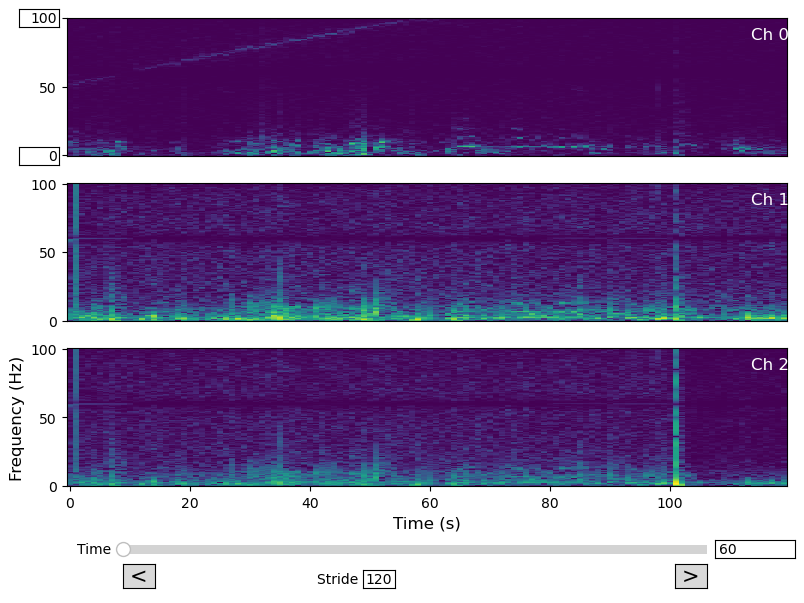

In [22]:
# plot again inline so we can talk about it
%matplotlib inline
STFTViewer(freqs, t, x)

Lets discuss what you are seeing in this viewer. At each time the squared magnitude of the STFT is displayed as a column vector. You can think of this as a short time PSD with frequencies along the vertical axis. <b>Notice the spectrogram shows non-stationarity.</b> There is the appearance and disappearance of frequencies every 5-10 seconds. This is a rich dataset to ask questions about non-stationary EEGs!

## References

<b>Introduction to probability, statistics, and random processes</b> by H. Pishro-Nik, , available at https://www.probabilitycourse.com, Kappa Research LLC, 2014.

<b>A NONPARAMETRIC TEST FOR STATIONARITY BASED ON LOCAL FOURIER ANALYSIS</b> by Prabahan Basu, Daniel Rudoy, and Patrick J. Wolfe. IEEE International Conference on Acoustics, Speech and Signal Processing, Taipei, 19-24 April 2009, 3005-3008.

<b>Introduction to Applied Statistical Signal Analysis : Guide to Biomedical and Electrical Engineering Applications.</b> by Shiavi R. 2007, 3rd ed.

<b>The Dependence of Electrode Impedance on the Number of Performed EEG Examinations</b> by Joanna Górecka and Przemysław Makiewicz, Sensors 2019, 19(11), 2608; https://doi.org/10.3390/s19112608

<b>In‐vivo measurements of human brain tissue conductivity using focal electrical current injection through intracerebral multicontact electrodes.</b> Laurent Koessler, Sophie Colnat‐Coulbois, Thierry Cecchin, Janis Hofmanis, Jacek P. Dmochowski, Anthony M. Norcia, Louis G. Maillard. Human Brain Mapping. 38 2016.

<b>SciPy 1.0: Fundamental Algorithms for Scientific Computing in Python. Nature Methods, 17(3), 261-272.</b>
 <br>
 Pauli Virtanen, Ralf Gommers, Travis E. Oliphant, Matt Haberland, Tyler Reddy, David Cournapeau, Evgeni Burovski, Pearu Peterson, Warren Weckesser, Jonathan Bright, Stéfan J. van der Walt, Matthew Brett, Joshua Wilson, K. Jarrod Millman, Nikolay Mayorov, Andrew R. J. Nelson, Eric Jones, Robert Kern, Eric Larson, CJ Carey, İlhan Polat, Yu Feng, Eric W. Moore, Jake VanderPlas, Denis Laxalde, Josef Perktold, Robert Cimrman, Ian Henriksen, E.A. Quintero, Charles R Harris, Anne M. Archibald, Antônio H. Ribeiro, Fabian Pedregosa, Paul van Mulbregt, and SciPy 1.0 Contributors. (2020)
 
 <b>Harris, C.R., Millman, K.J., van der Walt, S.J. et al. Array programming with NumPy. Nature 585, 357–362 (2020).</b>